### Import Libraries

In [5]:
# Standard libraries
import csv
import json
import os
import re
import shutil

# Data processing and analysis
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, f1_score, recall_score, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing and OCR
from PIL import Image, ImageDraw
import cv2
import pytesseract

# Transformers and huggingface_hub
from huggingface_hub import hf_hub_download
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection

# PyTorch
import torch

In [2]:
# Constants
DATA_PATH = 'C:/Users/nick2/Desktop/Table Transformer/'
TESSERACT_PATH = r'C:/Program Files/Tesseract-OCR/tesseract'

# Read the CSV file into a DataFrame
test_labels = pd.read_csv(os.path.join(DATA_PATH, 'Labeled Data.csv'))
test_labels['Pred'] = None

# Set working directory
working_directory = os.path.join(DATA_PATH, 'Test Dataset')
os.chdir(working_directory)

# Set tesseract path
pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

# List all files and get their full paths
files = os.listdir()
concatenated_paths = [os.path.join(working_directory, filename) for filename in files]


# 1. Table Recognition (Nick, Theo, Kose)

In [4]:
VALID_EXTENSIONS = {'.jpg', '.png'}
COLORS = [
    [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]
]

# Define Model and Feature Extractor
feature_extractor = DetrFeatureExtractor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

# Functions
def get_valid_images(directory):
    """Get valid image files from a directory."""
    all_files = [os.path.join(directory, file) for file in os.listdir(directory)
                 if os.path.isfile(os.path.join(directory, file))
                 and os.path.splitext(file)[1].lower() in VALID_EXTENSIONS]
    return all_files

def process_directory(directory, plot=False):
    """Process all valid images in a directory and return a DataFrame."""
    print(f"Processing images in directory: {os.path.basename(directory)}")
    
    all_files = get_valid_images(directory)
    all_data = []
    
    for image_file in all_files:
        data = process_image(image_file, base_save_path=directory, plot=plot)  # provide base_save_path here
        if data:
            all_data.append(data)
    
    return pd.DataFrame(all_data)


def process_image(file_name, base_save_path, buffer=50, plot=True):
    base_file_name = os.path.basename(file_name).rsplit('.', 1)[0]
    file_parts = base_file_name.split('_')
    
    image = Image.open(file_name).convert("RGB")
    img_cv = cv2.imread(file_name)
    width, height = image.size
    encoding = feature_extractor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.94, target_sizes=[(height, width)])[0]
    num_tables = len(results['scores'])

    boxes = results['boxes'] # Direct extraction from results
    if len(boxes) > 0:
        specific_save_path = os.path.join(base_save_path, f"{base_file_name} Cropped Images")
        if not os.path.exists(specific_save_path):
            os.makedirs(specific_save_path)

        for index, box in enumerate(boxes):
            x1 = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            x1 = max(0, x1 - buffer)
            y1 = max(0, y1 - buffer)
            x2 = min(img_cv.shape[1], x2 + buffer)
            y2 = min(img_cv.shape[0], y2 + buffer)
            
            cropped_img = img_cv[y1:y2, x1:x2]
            cv2.imwrite(f"{specific_save_path}/{base_file_name}_table_{index}.png", cropped_img)

    if plot and num_tables > 0:
        plot_results(image, results['scores'], results['labels'], results['boxes'])

    if len(file_parts) == 2:
        return {'FileName': file_parts[0], 'Page Number': file_parts[1], 'Number of tables': num_tables}
    else:
        return None

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Main execution
all_data = []

for path in concatenated_paths:
    if os.path.isdir(path):
        df = process_directory(path, plot=False)
        all_data.append(df)
    elif os.path.isfile(path) and os.path.splitext(path)[1].lower() in VALID_EXTENSIONS:
        parent_dir = os.path.dirname(path)  # This is where our cropped images would be saved
        data = process_image(path, base_save_path=parent_dir, plot=False)
        if data:
            all_data.append(pd.DataFrame([data]))

# Concatenate all data into the master dataframe
master_df = pd.concat(all_data, ignore_index=True)

c:\Users\nick2\anaconda3\envs\tables-detr\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection

Processing images in directory: 108156


## 1.2 Evaluation of Table Prediction Accuracy (Theo)

Subset 0.90 - Start Row: 1, End Row: 480
Accuracy: 0.86, Precision: 0.89, Recall: 0.86, F1 Score: 0.87
Subset 0.91 - Start Row: 481, End Row: 960
Accuracy: 0.88, Precision: 0.90, Recall: 0.88, F1 Score: 0.88
Subset 0.92 - Start Row: 961, End Row: 1440
Accuracy: 0.89, Precision: 0.91, Recall: 0.89, F1 Score: 0.89
Subset 0.93 - Start Row: 1441, End Row: 1920
Accuracy: 0.91, Precision: 0.92, Recall: 0.91, F1 Score: 0.91
Subset 0.94 - Start Row: 1921, End Row: 2400
Accuracy: 0.92, Precision: 0.93, Recall: 0.92, F1 Score: 0.92
Subset 0.95 - Start Row: 2401, End Row: 2880
Accuracy: 0.93, Precision: 0.93, Recall: 0.93, F1 Score: 0.92


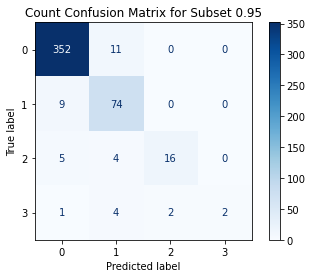

Subset 0.96 - Start Row: 2881, End Row: 3360
Accuracy: 0.93, Precision: 0.93, Recall: 0.93, F1 Score: 0.92
Subset 0.97 - Start Row: 3361, End Row: 3840
Accuracy: 0.93, Precision: 0.93, Recall: 0.93, F1 Score: 0.92
Subset 0.98 - Start Row: 3841, End Row: 4320
Accuracy: 0.92, Precision: 0.92, Recall: 0.92, F1 Score: 0.91


In [9]:
# Read your DataFrame from table_counts_threshold_099.csv

eval_path = 'C:/Users/nick2/Desktop/Capstone TT/Geological-Report-Similarity-Analysis/Capstone Project - Table Text Extraction/table_counts_threshold_099.csv'

df = pd.read_csv(eval_path)

# Define the subset size (number of rows per subset)
subset_size = 480  # 480 rows

# Calculate the number of subsets to create
num_subsets = len(df) // subset_size

# Define the subset index to display the confusion matrix (6th subset)
display_subset_index = 5  # Indexing starts from 0

# Iterate through subsets and calculate performance metrics
for i in range(num_subsets):
    # Calculate the starting and ending indices for the current subset
    start_idx = i * subset_size
    end_idx = (i + 1) * subset_size

    # Extract the subset of the DataFrame
    subset_df = df.iloc[start_idx:end_idx]

    # Extract the "Table Detected (Model)" and "Table Detected (Human)" columns for this subset
    model_detected = subset_df['Table Detected (Model)']
    human_detected = subset_df['Table Detected (Human)']

    # Filter out any detections over 3 (replace values greater than 3 with 3)
    model_detected = np.minimum(model_detected, 3)
    human_detected = np.minimum(human_detected, 3)

    # Calculate and save accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(human_detected, model_detected)
    precision = precision_score(human_detected, model_detected, average='weighted', zero_division=0)
    recall = recall_score(human_detected, model_detected, average='weighted', zero_division=0)
    f1 = f1_score(human_detected, model_detected, average='weighted', zero_division=0)

    # Display the start and end rows for this subset
    subset_title = 0.9 + i / 100  # Convert index to subset title
    print(f'Subset {subset_title:.2f} - Start Row: {start_idx + 1}, End Row: {end_idx}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

    # Check if this is the 6th subset (display_subset_index)
    if i == display_subset_index:
        # Create the confusion matrix for this subset
        confusion = confusion_matrix(human_detected, model_detected)

        # Define class labels for the confusion matrix (0 to 3)
        class_labels_subset = ['0', '1', '2', '3']

        # Create a confusion matrix visualization using ConfusionMatrixDisplay with specified labels
        disp = ConfusionMatrixDisplay(confusion, display_labels=class_labels_subset)
        disp.plot(cmap=plt.cm.Blues, values_format='d')

        plt.title(f'Count Confusion Matrix for Subset {subset_title:.2f}')
        plt.show()
        plt.close()




Subset 0.90:
  Detected: 104, Detected%: 21.67%
  None: 319, None%: 66.46%
  Equal: 95, Equal%: 19.79%
  Less: 22, Less%: 4.58%
  More: 104, More%: 21.67%
  More Misclassified: 44, More Misclassified%: 9.17%
Subset 0.91:
  Detected: 103, Detected%: 21.46%
  None: 327, None%: 68.12%
  Equal: 95, Equal%: 19.79%
  Less: 22, Less%: 4.58%
  More: 103, More%: 21.46%
  More Misclassified: 36, More Misclassified%: 7.50%
Subset 0.92:
  Detected: 103, Detected%: 21.46%
  None: 334, None%: 69.58%
  Equal: 95, Equal%: 19.79%
  Less: 22, Less%: 4.58%
  More: 103, More%: 21.46%
  More Misclassified: 29, More Misclassified%: 6.04%
Subset 0.93:
  Detected: 103, Detected%: 21.46%
  None: 342, None%: 71.25%
  Equal: 95, Equal%: 19.79%
  Less: 22, Less%: 4.58%
  More: 103, More%: 21.46%
  More Misclassified: 21, More Misclassified%: 4.38%
Subset 0.94:
  Detected: 103, Detected%: 21.46%
  None: 349, None%: 72.71%
  Equal: 94, Equal%: 19.58%
  Less: 23, Less%: 4.79%
  More: 103, More%: 21.46%
  More Miscla

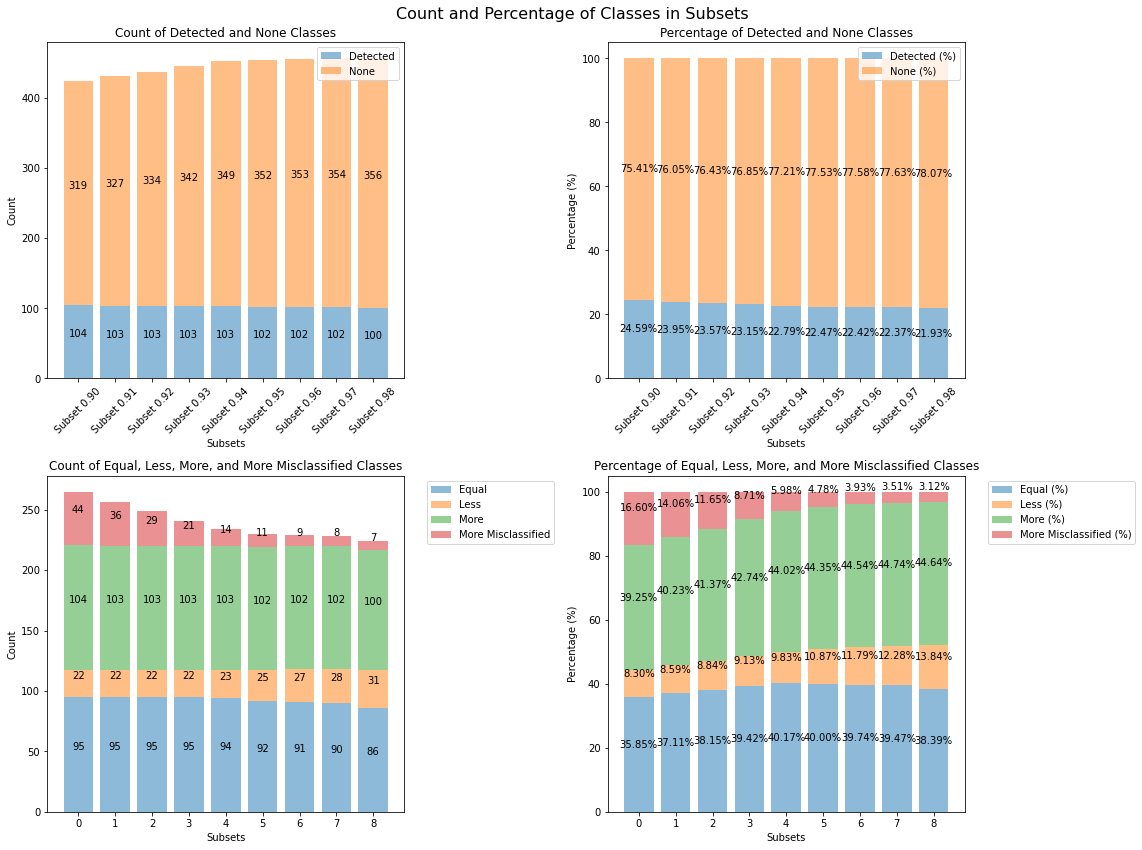

In [10]:
# Load the DataFrame from the CSV file
df = pd.read_csv(eval_path)

# Define the subset size (number of rows per subset)
subset_size = 480  # 480 rows

# Calculate the number of subsets to create
num_subsets = len(df) // subset_size

# Define a variable for renaming subsets
subset_name = 0.90

# Initialize lists to store count and percentage values
detected_counts = []
none_counts = []
equal_counts = []
less_counts = []
more_counts = []
more_misclassified_counts = []

# Iterate through subsets and calculate count and percentage values
for i in range(num_subsets):
    # Calculate the starting and ending indices for the current subset
    start_idx = i * subset_size
    end_idx = (i + 1) * subset_size

    # Extract the subset of the DataFrame
    subset_df = df.iloc[start_idx:end_idx]

    # Extract the "Table Detected (Model)" and "Table Detected (Human)" columns for this subset
    model_detected = subset_df['Table Detected (Model)']
    human_detected = subset_df['Table Detected (Human)']

    # Calculate the count of 'Detected' and 'None' classes
    detected_count = ((model_detected > 0) & (human_detected > 0)).sum()
    none_count = ((model_detected == 0) & (human_detected == 0)).sum()

    # Calculate the count of 'Equal,' 'Less,' and 'More' classes
    equal_count = ((model_detected == human_detected) & (model_detected > 0) & (human_detected > 0)).sum()  # Added condition
    less_count = ((model_detected < human_detected) & ((model_detected > 0) | (human_detected > 0))).sum()
    more_count = ((model_detected > 0) & (human_detected > 0)).sum()  # Modified to consider only both > 0
    more_misclassified_count = ((model_detected > human_detected) & (human_detected == 0) & (model_detected > 0)).sum()

    # Append the count values to the respective lists
    detected_counts.append(detected_count)
    none_counts.append(none_count)
    equal_counts.append(equal_count)
    less_counts.append(less_count)
    more_counts.append(more_count)
    more_misclassified_counts.append(more_misclassified_count)

    # Calculate percentages
    total_samples = len(subset_df)
    detected_percentage = (detected_count / total_samples) * 100
    none_percentage = (none_count / total_samples) * 100
    equal_percentage = (equal_count / total_samples) * 100
    less_percentage = (less_count / total_samples) * 100
    more_percentage = (more_count / total_samples) * 100
    more_misclassified_percentage = (more_misclassified_count / total_samples) * 100

    # Create strings for printing
    count_and_percentage_strings = []
    count_and_percentage_strings.append(f"Subset {subset_name:.2f}:")
    count_and_percentage_strings.append(f"  Detected: {detected_count}, Detected%: {detected_percentage:.2f}%")
    count_and_percentage_strings.append(f"  None: {none_count}, None%: {none_percentage:.2f}%")
    count_and_percentage_strings.append(f"  Equal: {equal_count}, Equal%: {equal_percentage:.2f}%")
    count_and_percentage_strings.append(f"  Less: {less_count}, Less%: {less_percentage:.2f}%")
    count_and_percentage_strings.append(f"  More: {more_count}, More%: {more_percentage:.2f}%")
    count_and_percentage_strings.append(f"  More Misclassified: {more_misclassified_count}, More Misclassified%: {more_misclassified_percentage:.2f}%")

    # Print count and percentage strings
    for line in count_and_percentage_strings:
        print(line)

    # Increment the subset name
    subset_name += 0.01

# Create four subplots (two for counts and two for percentages) with the original size
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Larger plot size
fig.suptitle('Count and Percentage of Classes in Subsets', fontsize=16)


# Subplot for counts of 'Detected' and 'None' classes
x = np.arange(len(detected_counts))
bars_det = axes[0, 0].bar(x, detected_counts, label='Detected', alpha=0.5)
bars_none = axes[0, 0].bar(x, none_counts, label='None', alpha=0.5, bottom=detected_counts)
axes[0, 0].set_xlabel('Subsets')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Count of Detected and None Classes')
axes[0, 0].set_xticks(x)
axes[0, 0].legend(loc='upper right')  # Legend placed outside the plot
axes[0, 0].set_xticklabels([f"Subset {subset_name:.2f}" for subset_name in np.arange(0.90, 0.90 + num_subsets * 0.01, 0.01)], rotation=45)

# Add labels on the bars for counts of 'Detected' and 'None' classes
for bar_det, bar_none, label_det, label_none in zip(bars_det, bars_none, detected_counts, none_counts):
    height_det = bar_det.get_height()
    height_none = bar_none.get_height()
    axes[0, 0].annotate(f'{label_det}', xy=(bar_det.get_x() + bar_det.get_width() / 2, height_det / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[0, 0].annotate(f'{label_none}', xy=(bar_none.get_x() + bar_none.get_width() / 2, height_det + height_none / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Subplot for percentages of 'Detected' and 'None' classes
x = np.arange(len(detected_counts))
detected_percentages = [(count / (count + none_counts[i])) * 100 for i, count in enumerate(detected_counts)]
none_percentages = [(count / (count + detected_counts[i])) * 100 for i, count in enumerate(none_counts)]

bars_det = axes[0, 1].bar(x, detected_percentages, label='Detected (%)', alpha=0.5)
bars_none = axes[0, 1].bar(x, none_percentages, label='None (%)', alpha=0.5, bottom=detected_percentages)
axes[0, 1].set_xlabel('Subsets')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_title('Percentage of Detected and None Classes')
axes[0, 1].set_xticks(x)
axes[0, 1].legend(loc='upper right')  # Legend placed outside the plot
axes[0, 1].set_xticklabels([f"Subset {subset_name:.2f}" for subset_name in np.arange(0.90, 0.90 + num_subsets * 0.01, 0.01)], rotation=45)

# Add labels on the bars for percentages of 'Detected' and 'None' classes
for bar_det, bar_none, label_det, label_none in zip(bars_det, bars_none, detected_percentages, none_percentages):
    height_det = bar_det.get_height()
    height_none = bar_none.get_height()
    axes[0, 1].annotate(f'{label_det:.2f}%', xy=(bar_det.get_x() + bar_det.get_width() / 2, height_det / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[0, 1].annotate(f'{label_none:.2f}%', xy=(bar_none.get_x() + bar_none.get_width() / 2, height_det + height_none / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Subplot for counts of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
x = np.arange(len(equal_counts))
bars_equal = axes[1, 0].bar(x, equal_counts, label='Equal', alpha=0.5)
bars_less = axes[1, 0].bar(x, less_counts, label='Less', alpha=0.5, bottom=equal_counts)
bars_more = axes[1, 0].bar(x, more_counts, label='More', alpha=0.5, bottom=np.array(equal_counts) + np.array(less_counts))
bars_more_misclassified = axes[1, 0].bar(x, more_misclassified_counts, label='More Misclassified', alpha=0.5,
                                          bottom=np.array(equal_counts) + np.array(less_counts) + np.array(more_counts))
axes[1, 0].set_xlabel('Subsets')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Count of Equal, Less, More, and More Misclassified Classes')
axes[1, 0].set_xticks(x)
axes[1, 0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend placed outside to the right

# Add labels on the bars for counts of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
for bar_equal, bar_less, bar_more, bar_more_misclassified, label_equal, label_less, label_more, label_more_misclassified in zip(
        bars_equal, bars_less, bars_more, bars_more_misclassified, equal_counts, less_counts, more_counts, more_misclassified_counts):
    height_equal = bar_equal.get_height()
    height_less = bar_less.get_height()
    height_more = bar_more.get_height()
    height_more_misclassified = bar_more_misclassified.get_height()
    axes[1, 0].annotate(f'{label_equal}', xy=(bar_equal.get_x() + bar_equal.get_width() / 2, height_equal / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[1, 0].annotate(f'{label_less}', xy=(bar_less.get_x() + bar_less.get_width() / 2, height_equal + height_less / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[1, 0].annotate(f'{label_more}', xy=(bar_more.get_x() + bar_more.get_width() / 2, height_equal + height_less + height_more / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[1, 0].annotate(f'{label_more_misclassified}', xy=(bar_more_misclassified.get_x() + bar_more_misclassified.get_width() / 2,
                                                           height_equal + height_less + height_more + height_more_misclassified / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Subplot for percentages of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
x = np.arange(len(equal_counts))
equal_percentages = [(count / (count + less_counts[i] + more_counts[i] + more_misclassified_counts[i])) * 100 for i, count in enumerate(equal_counts)]
less_percentages = [(count / (count + equal_counts[i] + more_counts[i] + more_misclassified_counts[i])) * 100 for i, count in enumerate(less_counts)]
more_percentages = [(count / (count + equal_counts[i] + less_counts[i] + more_misclassified_counts[i])) * 100 for i, count in enumerate(more_counts)]
more_misclassified_percentages = [(count / (count + equal_counts[i] + less_counts[i] + more_counts[i])) * 100 for i, count in enumerate(more_misclassified_counts)]

bars_equal = axes[1, 1].bar(x, equal_percentages, label='Equal (%)', alpha=0.5)
bars_less = axes[1, 1].bar(x, less_percentages, label='Less (%)', alpha=0.5, bottom=equal_percentages)
bars_more = axes[1, 1].bar(x, more_percentages, label='More (%)', alpha=0.5,
                          bottom=np.array(equal_percentages) + np.array(less_percentages))
bars_more_misclassified = axes[1, 1].bar(x, more_misclassified_percentages, label='More Misclassified (%)', alpha=0.5,
                                          bottom=np.array(equal_percentages) + np.array(less_percentages) + np.array(more_percentages))
axes[1, 1].set_xlabel('Subsets')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('Percentage of Equal, Less, More, and More Misclassified Classes')
axes[1, 1].set_xticks(x)
axes[1, 1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend placed outside to the right

# Add labels on the bars for percentages of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
for bar_equal, bar_less, bar_more, bar_more_misclassified, label_equal, label_less, label_more, label_more_misclassified in zip(
        bars_equal, bars_less, bars_more, bars_more_misclassified, equal_percentages, less_percentages, more_percentages, more_misclassified_percentages):
    height_equal = bar_equal.get_height()
    height_less = bar_less.get_height()
    height_more = bar_more.get_height()
    height_more_misclassified = bar_more_misclassified.get_height()
    axes[1, 1].annotate(f'{label_equal:.2f}%', xy=(bar_equal.get_x() + bar_equal.get_width() / 2, height_equal / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[1, 1].annotate(f'{label_less:.2f}%', xy=(bar_less.get_x() + bar_less.get_width() / 2, height_equal + height_less / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[1, 1].annotate(f'{label_more:.2f}%', xy=(bar_more.get_x() + bar_more.get_width() / 2, height_equal + height_less + height_more / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[1, 1].annotate(f'{label_more_misclassified:.2f}%',
                       xy=(bar_more_misclassified.get_x() + bar_more_misclassified.get_width() / 2,
                           height_equal + height_less + height_more + height_more_misclassified / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2.1 Perform Table Data Extraction Using Morphological Operations Tesseract (Nick, Jiyun)

In [11]:
def find_subdirs_with_name(path, keyword):
    """Return all subdirectories containing the given keyword."""
    return [os.path.join(root, directory) for root, dirs, files in os.walk(path) for directory in dirs if keyword in directory]

def find_image_files_in_dir(path):
    """Return all image files in the directory."""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    return [os.path.join(root, file) for root, dirs, files in os.walk(path) for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]


def process_image(image_path):
    image = cv2.imread(image_path, 0)
    
    img_bin = 255 - image
    _, img_bin_otsu = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Vertical Line extraction
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img_bin_otsu).shape[1]//150))
    eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=5)
    vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=5)
    
    # Horizontal Line extraction
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img_bin_otsu).shape[1]//150, 1))
    image_2 = cv2.erode(img_bin_otsu, hor_kernel, iterations=5)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=5)

    # Combining
    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
    _, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    b_image = cv2.bitwise_not(cv2.bitwise_xor(image, vertical_horizontal_lines))
    return b_image, vertical_horizontal_lines


def extract_bounding_boxes(b_image, vertical_horizontal_lines):
    contours, _ = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda x: x[1][1]))

    boxes = []
    image_copy = b_image.copy()  # Initialize image_copy here
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x-=1
        w+=1
        if w < 1000 and h < 500:
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
            boxes.append([x, y, w, h])
            
    # Uncomment Section to show plots
    # plt.imshow(image_copy, cmap='gray')
    # plt.title("Identified contours")
    # plt.show()
    return boxes

def extract_text_from_boxes(b_image, boxes):
    rows = []
    columns = []
    heights = [box[3] for box in boxes]  # Extracting the heights of all boxes
    mean_height = np.mean(heights)

    # Initialize columns list with the first box and set the previous box to the first box
    columns.append(boxes[0])
    previous_box = boxes[0]

    for i in range(1, len(boxes)):
        if boxes[i][1] <= previous_box[1] + mean_height / 2:
            columns.append(boxes[i])
            previous_box = boxes[i]
            if i == len(boxes) - 1:
                rows.append(columns)
        else:
            rows.append(columns)
            columns = []
            previous_box = boxes[i]
            columns.append(boxes[i])

    # Determine the total number of cells in the row with the maximum cells
    total_cells = max([len(r) for r in rows])

    # Find the center of each box in the first row
    centers = [int(rows[0][j][0] + rows[0][j][2] / 2) for j in range(len(rows[0]))]
    centers = np.array(centers)
    centers.sort()

    # Organize boxes by their closest center position
    boxes_list = []
    for i in range(len(rows)):
        l = [[] for _ in range(total_cells)]
        for j in range(len(rows[i])):
            # Find the closest center for the current box
            diff = abs(centers - (rows[i][j][0] + rows[i][j][2] / 4))
            minimum = min(diff)
            index = list(diff).index(minimum)
            l[index].append(rows[i][j])
        boxes_list.append(l)

    # Extracting text from cells in the image
    dataframe_final = []
    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            s = ''
            if len(boxes_list[i][j]) == 0:
                dataframe_final.append(' ')
            else:
                for k in range(len(boxes_list[i][j])):
                    x, y, w, h = boxes_list[i][j][k]
                    roi = b_image[y:y+h, x:x+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel, iterations=1)
                    erosion = cv2.erode(dilation, kernel, iterations=2)
                    out = pytesseract.image_to_string(erosion).strip()
                    s += " " + out
                dataframe_final.append(s)

    arr = np.array(dataframe_final)
    dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))

    return dataframe

def ocr_image_to_text(image_path, extracted_dir, counter):
    b_image, vertical_horizontal_lines = process_image(image_path)
    boxes = extract_bounding_boxes(b_image, vertical_horizontal_lines)

    if len(boxes) <= 1:
        print("No Table Detected.")
        return counter  # Return the current counter value
    else:
        print('Table Extracted!')
        dataframe = extract_text_from_boxes(b_image, boxes)
        
        output_dir = os.path.dirname(extracted_dir)
        if counter == 0:
            csv_output_path = os.path.join(output_dir, "output.csv")
        else:
            csv_output_path = os.path.join(output_dir, f"output{counter}.csv")
        
        dataframe.to_csv(csv_output_path, index=False, header=False)

        counter += 1  # Increment the counter
    return counter  # Return the updated counter value

def process_images_in_extracted_dirs(main_wd, output_dir):
    global processed_tables_counter  # Declare the global variable here
    cropped_dirs = find_subdirs_with_name(main_wd, "Cropped")
    processed_tables_counter = 0 
    for extracted_dir in cropped_dirs:
        for image_path in find_image_files_in_dir(extracted_dir):
            # Update the counter with the returned value
            processed_tables_counter = ocr_image_to_text(image_path, extracted_dir, processed_tables_counter)



# Example usage
 # Introduce a global counter
main_wd = r'C:\Users\nick2\Desktop\Table Transformer\Test Dataset'
output_directory = os.path.dirname(main_wd)
process_images_in_extracted_dirs(main_wd, output_directory)


Table Extracted!
Table Extracted!
No Table Detected.
Table Extracted!


KeyboardInterrupt: 

# 2.2 Perform Table Data Extraction Using Paddle OCR

# Table Extraction Evaluation (Jiyun)